In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, generation, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
import tensorflow as tf
from datasets import Dataset
import tqdm as notebook_tqdm


In [ ]:
model_name = 'PlanTL-GOB-ES/roberta-large-bne'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/858k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/516k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoTokenizer
import pandas as pd

def concatenar_hasta_limite(tweets, max_longitud=None):
    segmentos = []
    segmento_actual = ""

    for tweet in tweets:
        # Tokenizar el segmento actual junto con el nuevo tweet
        # y contar el número total de tokens
        token_count = len(tokenizer(segmento_actual + tweet + " ", add_special_tokens=False)['input_ids'])

        # Revisar la longitud del próximo segmento potencial en términos de tokens
        if token_count <= max_longitud:
            segmento_actual += tweet
        else:
            # Guardar el segmento actual y comenzar uno nuevo
            segmentos.append(segmento_actual.strip())
            segmento_actual = tweet

    # No olvidar agregar el último segmento
    if segmento_actual:
        segmentos.append(segmento_actual.strip())

    return segmentos

# Asumiendo que df_train_full es tu DataFrame y ya está cargado
df_segmentado = pd.DataFrame()

# Usar una longitud máxima de tokens (por ejemplo, 512 para BERT)
max_tokens = 512

for (label, ideology), group in df_train_full.groupby(['label', 'ideology_multiclass']):
    segmentos = concatenar_hasta_limite(group['tweet'], max_tokens)
    segmento_data = [{'label': label, 'ideology_multiclass': ideology, 'tweet': segmento} for segmento in segmentos]
    df_segmentado = pd.concat([df_segmentado, pd.DataFrame(segmento_data)], ignore_index=True)



In [ ]:
# Mostrar las primeras filas del DataFrame resultante
df_segmentado.head(10)

,label,ideology_multiclass,tweet
0,0008c4fab9e97623a60380ee9c88cb20,left,¡Feliz 28 de febrero a todas las andaluzas y a...
1,0008c4fab9e97623a60380ee9c88cb20,left,Una de las mejores noticias del día. Apostar p...
2,0008c4fab9e97623a60380ee9c88cb20,left,Las personas que integran la Inspección de Tra...
3,0008c4fab9e97623a60380ee9c88cb20,left,El reto hoy es ensanchar la democracia y hay q...
4,0008c4fab9e97623a60380ee9c88cb20,left,¡Este sábado nos vemos en Valladolid para @use...
5,0008c4fab9e97623a60380ee9c88cb20,left,Una de las prioridades principales del Gobiern...
6,0008c4fab9e97623a60380ee9c88cb20,left,La crisis internacional provocada por la guerr...
7,0008c4fab9e97623a60380ee9c88cb20,left,En mi visita a la isla de Zorrotzaurre en Bilb...
8,00369358fac3b8d42845f82f0c3ececc,left,"@user Escribió un libro resultón, con gracejo,..."
9,00369358fac3b8d42845f82f0c3ececc,left,"Lo que sí es ""miserable"" y ""cobarde"" es abando..."


In [ ]:
df_segmentado.to_csv('df_segmentado.csv')

In [ ]:
df_segmentado= pd.read_csv('df_segmentado_mejor.csv', on_bad_lines='skip')

In [ ]:
df_segmentado.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [ ]:
df_train= df_segmentado.copy()

In [ ]:
df_train.drop(['label'], axis=1, inplace=True)

##  Clasificador

In [ ]:
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86

In [ ]:
label_encoder = LabelEncoder()

df_train['ideology_multiclass'] = label_encoder.fit_transform(df_train['ideology_multiclass'])

#df_train['tweet'] = df_train['tweet'].apply(lambda x: x.replace("@user", "<usr>"))

df_train, df_eval= train_test_split(df_train, test_size=0.2, stratify= df_train['ideology_multiclass'], random_state=42)

In [ ]:
def tokenize_function(example):
    return tokenizer(example['tweet'])

dataset_train = Dataset.from_pandas(df_train)
dataset_eval = Dataset.from_pandas(df_eval)

In [ ]:
# Aplicamos la tokenización a todo el dataset
tokenized_dataset_train = dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_eval = dataset_eval.map(tokenize_function, batched=True)
tokenized_dataset_train

Map:   0%|          | 0/12336 [00:00<?, ? examples/s]

Map:   0%|          | 0/3085 [00:00<?, ? examples/s]

Dataset({
    features: ['ideology_multiclass', 'tweet', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 12336
})

In [ ]:
tokenized_dataset_train= tokenized_dataset_train.rename_column("ideology_multiclass", "labels")
tokenized_dataset_train= tokenized_dataset_train.remove_columns(["tweet","__index_level_0__"])

tokenized_dataset_eval= tokenized_dataset_eval.rename_column("ideology_multiclass", "labels")
tokenized_dataset_eval= tokenized_dataset_eval.remove_columns(["tweet","__index_level_0__"])  # Nos quedamos solo con los valores que necesita el modelo
tokenized_dataset_train

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 12336
})

In [ ]:
from datasets import DatasetDict


# Creamos un DatasetDict para organizar los subconjuntos
final_datasets = DatasetDict({
    'train': tokenized_dataset_train,
    'validation': tokenized_dataset_eval,

})

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # Introducimos el data collator para trabajar con padding dinámico

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Macro-f1
616,1.184000,0.956754,0.566107
1232,0.894100,0.905177,0.698958
1848,0.854500,0.767313,0.746635
2464,0.765900,0.738212,0.779301
3080,0.676000,0.832002,0.742874


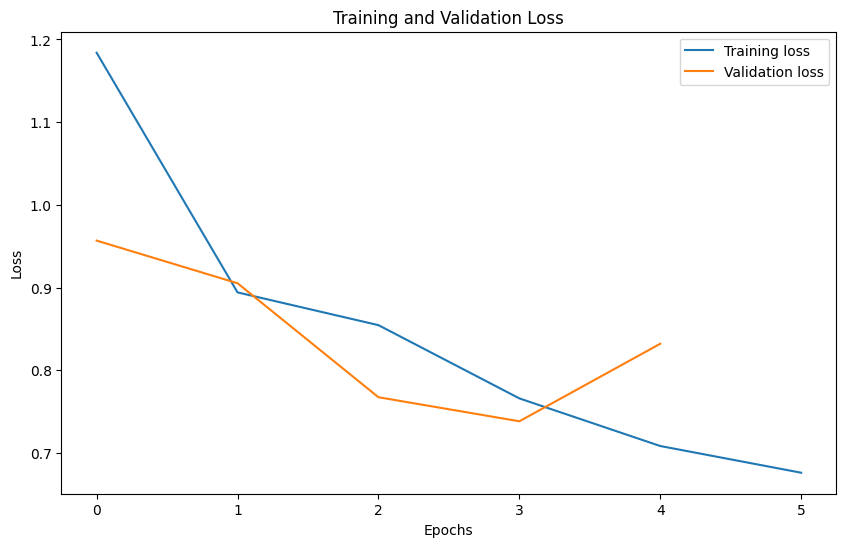

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import matplotlib.pyplot as plt

# Definimos la función encargada de evaluar las métricas en el entrenamiento
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)
    macro_f1 = f1_score(labels, predictions, average='macro') # o weighted si estan desbalceadas las clases

    return {'macro-F1': macro_f1}



# Definimos los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy='steps',
    eval_steps=616,
    save_strategy='steps',
    save_steps=616,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=42,
)

# Inicializamos el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets['train'],
    eval_dataset=final_datasets['validation'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0)]
)

# Entrenamiento y evaluación
trainer.train()
training_stats = trainer.state.log_history

# Representación de las pérdidas a lo largo de las épocas
training_loss = [e['loss'] for e in training_stats if 'loss' in e]
validation_loss = [e['eval_loss'] for e in training_stats if 'eval_loss' in e]

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
model.save_pretrained("marIA-ideologiamul-none-label", push_to_hub=True)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
tokenizer.save_pretrained("marIA-ideologiamul-none-label", push_to_hub=True)

('marIA-ideologiamul-none-label/tokenizer_config.json',
 'marIA-ideologiamul-none-label/special_tokens_map.json',
 'marIA-ideologiamul-none-label/vocab.json',
 'marIA-ideologiamul-none-label/merges.txt',
 'marIA-ideologiamul-none-label/added_tokens.json',
 'marIA-ideologiamul-none-label/tokenizer.json')